# Compression of Images with MLSVD

In this notebook we will see how to compress a bitmap image using the MLSVD. Any image with colors can be seen as a $m \times n \times 3$ tensor, where each $m \times n$ slice corresponds to a specific color from the RGB encoding. More specifically, the first slice is the red slice, the seconds is green and the third is blue. Note we need to convert the tensor to uint8 format before and after the computations since this is the correct format for RGB images. 

The general idea is the following: transform an image in a $m \times n \times 3$ tensor $T$, choose some rank $R$ and compute an truncated MLSVD $S$ for $T$, where $S$ has shape $R \times R \times 3$. For this image we know that a reasonable value for $R$ is $R = 150$ (see the compression with CPD for more details on this). Compressing with MLSVD is much faster than with CPD, however the CPD method makes more compressing. Here the compression needs to store $3R^2 + Rm + Rn + 9$ floats, whereas the CPD method only needs to store $R(m+n+3)$ floats. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
# Add path to Tensor Fox and load the module.

# import sys
import sys

# read path 
path_tfx = '/home/felipe/PycharmProjects/tensorfox/'

# import module from the path given
sys.path.append(path_tfx)
import TensorFox as tfx
import TensorFox as tfx

In [2]:
# Prepare data.

T_uint8= np.array(Image.open('input.bmp'))
T = np.array(T_uint8, dtype = np.float64)
m, n, p = T.shape
Tsize = np.linalg.norm(T)
print(T.shape)

(2844, 2216, 3)


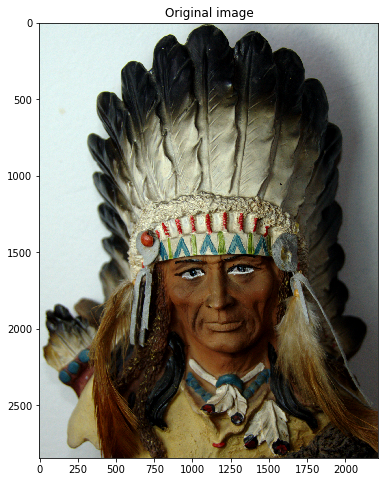

---------------------------------------------------------------
Accuracy of compressed version is of 95.39 %.
Compression is 22.88 times smaller than original.


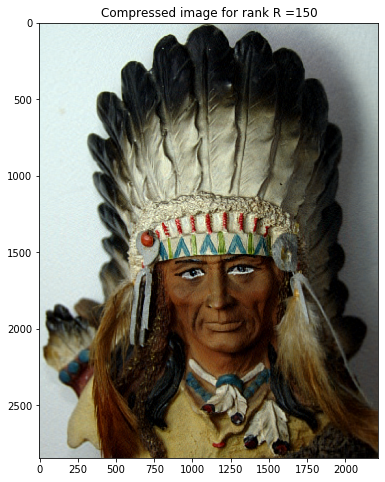

In [3]:
# Plot original image.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.imshow(T_uint8)
plt.title('Original image')
plt.show()

# Compute the MLSVD of T.

R = 150
class options:
    display = 3
S, U, T1, sigmas, rel_error = tfx.cmpr.mlsvd(T, Tsize, R, options)
    
print('---------------------------------------------------------------')
print('Accuracy of compressed version is of', np.round(100*(1 - rel_error), 2),'%.')
S_storage = S.size
U_storage = m*S.shape[0] + n*S.shape[1] + 3*S.shape[2]
print('Compression is', np.round(m*n*p/(S_storage + U_storage), 2), 'times smaller than original.' )

# Plot compressed image.
S1 = tfx.cnv.unfold(S, 1)
T_approx = tfx.mlinalg.multilin_mult(U, S1, S.shape)
T_approx = tfx.disp.adjust(T_approx, m, n, p)
T_approx_uint8 = np.array(T_approx, dtype = np.uint8)
plt.imshow(T_approx_uint8)
plt.title('Compressed image for rank R =' + str(R))
plt.show()

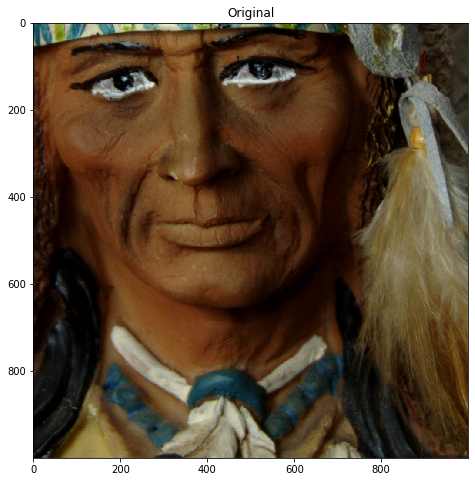

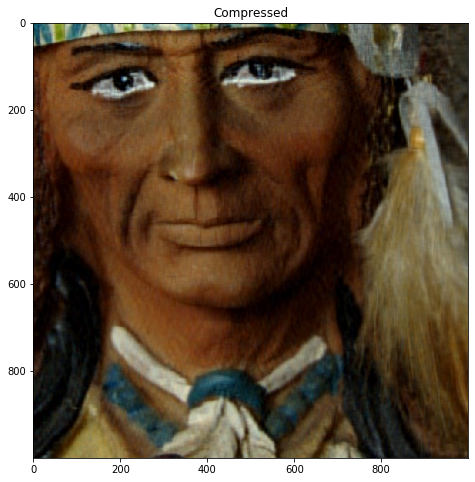

In [4]:
# Zoom in the last compression (rank = 350) and compare it to the original in more detail. 
# It is possible to see that still there are imperfections, which is to be expected in any compression.

plt.imshow(T_uint8[1500:2500, 800:1800])
plt.title('Original')
plt.show()

plt.imshow(T_approx_uint8[1500:2500, 800:1800])
plt.title('Compressed')
plt.show()

If you don't want to rely on $R$ and prefer to compute the compression via the MLSVD error only, set $R = \max(m, n, p)$ (this makes $R$ irrelevant to the MLSVD function) and play with the parameter $\verb|tol| \_ \verb|mlsvd|$. Note that $R$ is a bound to the dimensions of the central tensor $S$. To speed up the computations we recommend to set $R$ to a bound you think it's good enough. Below we show an example of how to do this.

---------------------------------------------------------------
Dimensions of central tensor:  (12, 5, 1)
Accuracy of compressed version is of 74.2 %.
Compression is 417.64 times smaller than original.


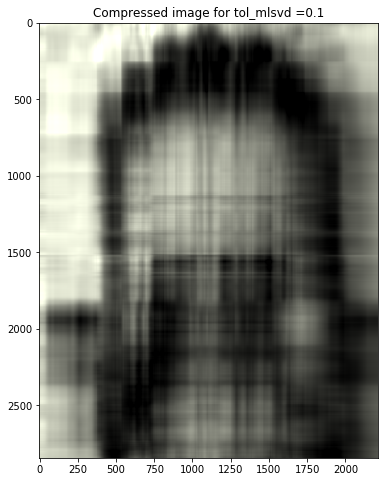

---------------------------------------------------------------
Dimensions of central tensor:  (87, 55, 2)
Accuracy of compressed version is of 91.34 %.
Compression is 49.9 times smaller than original.


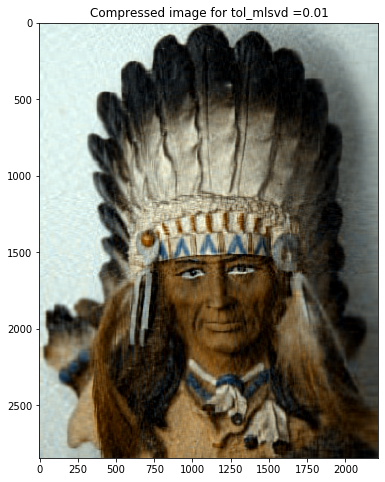

---------------------------------------------------------------
Dimensions of central tensor:  (295, 235, 3)
Accuracy of compressed version is of 96.71 %.
Compression is 12.06 times smaller than original.


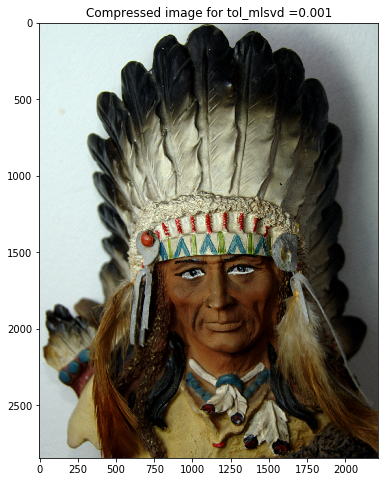

---------------------------------------------------------------
Dimensions of central tensor:  (463, 443, 3)
Accuracy of compressed version is of 97.69 %.
Compression is 6.49 times smaller than original.


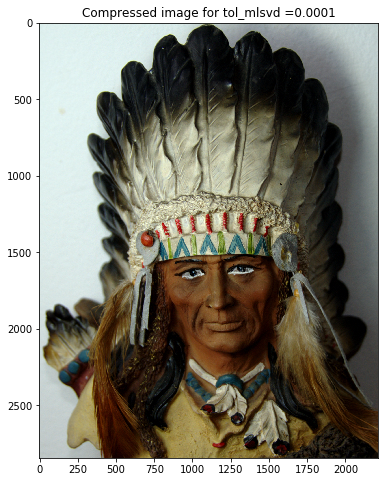

---------------------------------------------------------------
Dimensions of central tensor:  (496, 493, 3)
Accuracy of compressed version is of 97.79 %.
Compression is 5.84 times smaller than original.


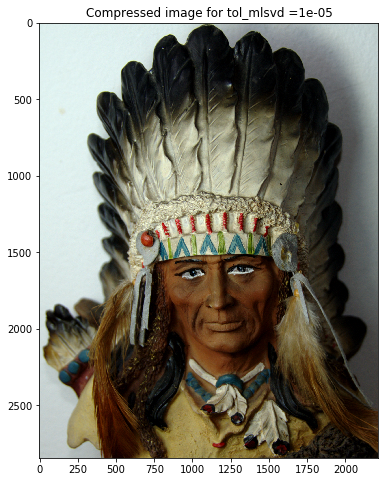

In [5]:
# Compute the several MLSVDs.

R = 500

# Initialize arrays with the quality of compression (accuracy) and level of compression (how many times
# the compressed tensor is smaller than the original tensor).
compression_quality = []
compression_level = []

for tol in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
    class options:
        display = 3
        tol_mlsvd = tol
    S, U, T1, sigmas, rel_error = tfx.cmpr.mlsvd(T, Tsize, R, options)
    S_storage = S.size
    U_storage = m*S.shape[0] + n*S.shape[1] + 3*S.shape[2]
    compression_quality.append(100*(1 - rel_error))
    compression_level.append(m*n*p/(S_storage + U_storage))
    
    print('---------------------------------------------------------------')
    print('Dimensions of central tensor: ', S.shape)
    print('Accuracy of compressed version is of', np.round(100*(1 - rel_error), 2),'%.')
    print('Compression is', np.round(m*n*p/(S_storage + U_storage), 2), 'times smaller than original.' )
    
    # Plot compressed image.
    S1 = tfx.cnv.unfold(S, 1)
    T_approx = tfx.mlinalg.multilin_mult(U, S1, S.shape)
    T_approx = tfx.disp.adjust(T_approx, m, n, p)
    T_approx_uint8 = np.array(T_approx, dtype = np.uint8)
    plt.imshow(T_approx_uint8)
    plt.title('Compressed image for tol_mlsvd =' + str(tol))
    plt.show()

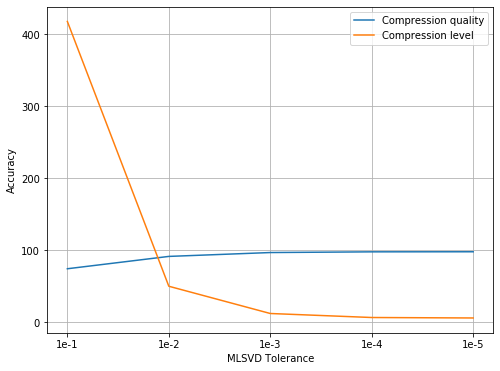

In [6]:
# Show the evolution of quality and compression level.

fig_size[0] = 8
fig_size[1] = 6
plt.plot(['1e-1', '1e-2', '1e-3', '1e-4', '1e-5'], compression_quality, label = 'Compression quality')
plt.plot(['1e-1', '1e-2', '1e-3', '1e-4', '1e-5'], compression_level, label = 'Compression level')
plt.xlabel('MLSVD Tolerance')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

We choose $\verb|tol| \_ \verb|mlsvd| = 10^{-4}$. Below we repeat the computation for this specific tolerance, and after that we save the final image.

Note that, although the compressed version is $6.49$ times smaller than the original (see below), this is with respect to the tensor representation, not the saved file. In fact, the original file (*input.bmp*) has $25.2$ MB, while the compressed image (*output.png*) has $7.0$ MB, which is $3.6$ times smaller than the original file.

In [7]:
R = 500
tol = 1e-4

class options:
    display = 3
    tol_mlsvd = tol

start = time.time()
S, U, T1, sigmas, rel_error = tfx.cmpr.mlsvd(T, Tsize, R, options)
end = time.time()

S_storage = S.size
U_storage = m*S.shape[0] + n*S.shape[1] + 3*S.shape[2]
compression_quality.append(100*(1 - rel_error))
compression_level.append(m*n*p/(S_storage + U_storage))

print('Computational time necessary to make the compression = ', np.round(end - start, 2), 'seconds')
print('Dimensions of central tensor: ', S.shape)
print('Accuracy of compressed version is of', np.round(100*(1 - rel_error), 2),'%.')
print('Compression is', np.round(m*n*p/(S_storage + U_storage), 2), 'times smaller than original.' )

# The CPD of a RGB image will have approximated values (float), not integers in the range [0, 255]. 
# The function adjust fix this issue. The output is still a float array, but with rounded values.
S1 = tfx.cnv.unfold(S, 1)
T_approx = tfx.mlinalg.multilin_mult(U, S1, S.shape)
T_approx = tfx.disp.adjust(T_approx, m, n, p)
T_approx_uint8 = np.array(T_approx, dtype = np.uint8)

# Save last compressed image.
img = Image.fromarray(T_approx_uint8) 
img.save("output_mlsvd.png")

Computational time necessary to make the compression =  5.32 seconds
Dimensions of central tensor:  (463, 443, 3)
Accuracy of compressed version is of 97.69 %.
Compression is 6.49 times smaller than original.


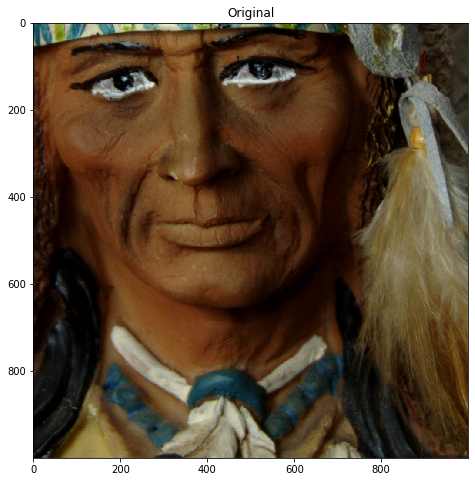

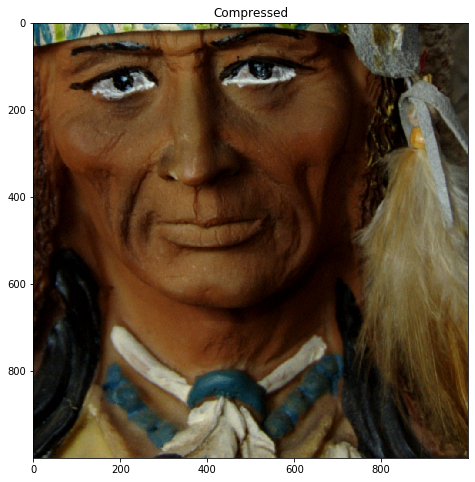

In [8]:
# Again we zoom in and compare it to the original in more detail. 
# It is possible to see that still there are imperfections, which is to be expected in any compression.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8

plt.imshow(T_uint8[1500:2500, 800:1800])
plt.title('Original')
plt.show()

plt.imshow(T_approx_uint8[1500:2500, 800:1800])
plt.title('Compressed')
plt.show()

We remark that the compressed tensor $S$ can also be visualized as a RGB image. However it is meaningless, it only show the energy distribution. Displaying $S$ may not be so useful but compressing and using $S$ for some work can be useful for some problems (for instance, it is possible to use it for [image classification](https://github.com/felipebottega/Tensor-Fox/blob/master/examples/digit_recognizer_mlsvd.ipynb)). Below we show $S$ as an image just for fun. 

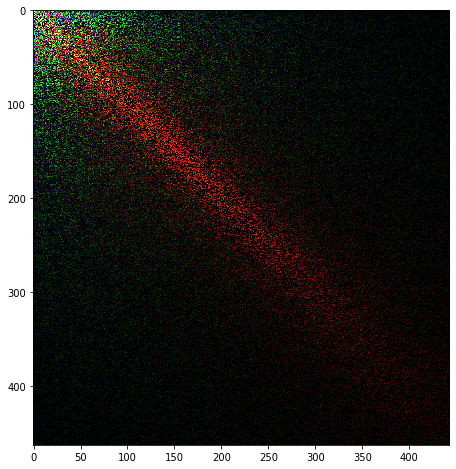

In [9]:
S = tfx.disp.adjust(S, S.shape[0], S.shape[1], S.shape[2])
S_uint8 = np.array(S, dtype = np.uint8)
plt.imshow(S_uint8)
plt.show()

Finally, we plot the slices of $S$ below.

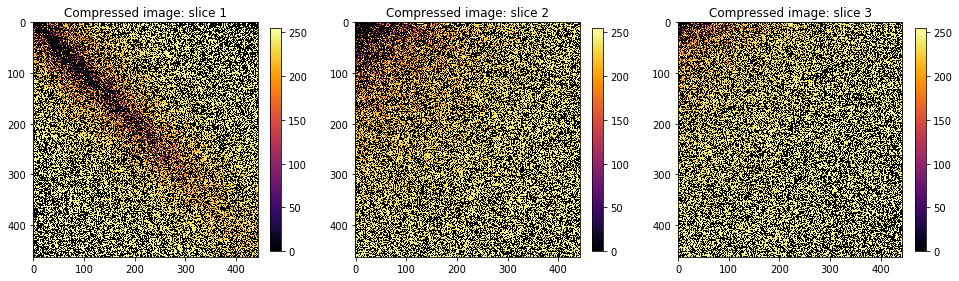

In [10]:
fig, ax = plt.subplots(1, 3, figsize=[16, 16])
for k in range(3):
    # Slice k
    im = ax[k].imshow(-S_uint8[:,:,k], cmap='inferno')
    ax[k].set_title('Compressed image: slice ' + str(k+1))
    fig.colorbar(im, ax=ax[k], fraction=0.045)
fig.subplots_adjust(wspace=0.3)
plt.show()